<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE30338](https://jckantor.github.io/CBE30338)
by Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE30338.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [Simulation and Optimal Control](http://nbviewer.jupyter.org/github/jckantor/CBE30338/blob/master/notebooks/07.00-Simulation-and-Optimal-Control.ipynb) | [Contents](toc.ipynb) | [Soft Landing a Rocket](http://nbviewer.jupyter.org/github/jckantor/CBE30338/blob/master/notebooks/07.02-Soft-Landing-a-Rocket.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE30338/blob/master/notebooks/07.01-Simulation-and-Optimal-Control-in-Pharmacokinetics.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE30338/master/notebooks/07.01-Simulation-and-Optimal-Control-in-Pharmacokinetics.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Simulation and Optimal Control in Pharmacokinetics

## Installations and Initialization

Pyomo and ipopt are now preinstalled on [Google Colaboratory](https://colab.research.google.com/). On MacOS and Windows PC, a one-time installation of pyomo and ipopt is required. The following commands will perform the needed installation when using the Anaconda distribution of Python.

In [0]:
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
ipopt_executable = '/content/ipopt'

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

On MacOS and Windows PC, a one-time installation of pyomo and ipopt is required. The following commands will perform the needed installation when using the Anaconda distribution of Python.

    !conda install -c conda-forge pyomo
    !conda install -c conda-forge pyomo.extras
    !conda install -c conda-forge ipopt

## A Pharmacokinetics Example

Pharmacokinetics -- the study of the drugs and other substances administered to a living organism -- is a rich source of examples for simulation and optimization. Here we discuss a solution to a very simple problem.

A patient is admitted to a clinic with a dangerous blood borne infection that needs to be treated with a specific antibiotic. The treatment requires a minimum therapeutic concentration of 20 mg/liter of blood, but, for safety reasons, should not exceed 40 mg/liter. The attending physician has established a target value of 25 mg/liter.  The antibiotic will be administered to the patient by continuous infusion over a 72 hour period using a pump capable of delivering up to 50 mg/hour.  

<a title="Pflegewiki-User Würfel [CC BY-SA 3.0 (http://creativecommons.org/licenses/by-sa/3.0/)], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Infusionspumpe.JPG"><img width="256" alt="Infusionspumpe" src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Infusionspumpe.JPG/256px-Infusionspumpe.JPG"></a>

Pflegewiki-User Würfel [CC BY-SA 3.0 (http://creativecommons.org/licenses/by-sa/3.0/)]

The research literature shows dynamics of antibiotic concentration in the body behaves according to a one-compartment pharmacokinetic model

\begin{align*}
V\frac{dC}{dt} & = u(t) - k C
\end{align*}

where $V$ is compartment volume (e.g., blood is about 5 liters in an adult), and $kC$ is the rate of elimination due to all sources, including metabolism and excretion. Based on an observed half-life in the blood of 8 hours, $k$ has an estimated value of 0.625 liters/hour. Given this information, what administration policy would you recommend?

## Simulation of Fixed Infusion Rate Strategy

The first strategy we will investigate is constant infusion.  At steady-state, the pharmacokinetic model becomes

\begin{align*}
\bar{u} & = k \bar{C} \\
& = 0.625 \times 25 \\
& = 15.625 \mbox{ mg/hr}
\end{align*}

The following cell simulates the patient response.

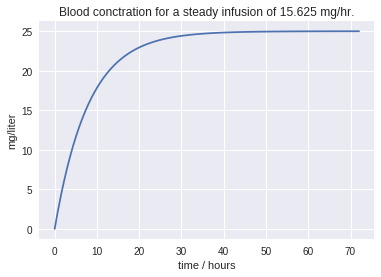

In [7]:
# parameters
t_final = 72     # hours
V = 5.0          # liters
k = 0.625        # liters/hour
u = 25*0.625     # mg/hour infusion rate

# create a model
model = ConcreteModel()

# define time as a continous set with bounds
model.t = ContinuousSet(bounds=(0, t_final))

# define problem variable indexed by time
model.C = Var(model.t, domain=NonNegativeReals)
model.dCdt = DerivativeVar(model.C, wrt=model.t)

# the differential equation is a constraint indexed by time
model.ode = Constraint(model.t, rule=lambda model, t: V*model.dCdt[t] == u - k*model.C[t])

# initial condition
model.C[0].fix(0)

# transform the model to a system of algebraic constraints
TransformationFactory('dae.finite_difference').apply_to(model, nfe=50, method='backwards')

# compute a solution using the Pyomo simulator capability
tsim, profiles = Simulator(model, package='scipy').simulate()

# plot results
plt.plot(tsim, profiles)
plt.xlabel('time / hours')
plt.ylabel('mg/liter')
plt.title('Blood conctration for a steady infusion of ' + str(u) + ' mg/hr.');

## Optimizing the Infusion Strategy

The simulation results show that a constant rate of infusion results in a prolonged period, more than twelve hours, where the antibiotic concentration is below the minimum therapuetic dose of 20 mg/liter. Can we find a better strategy?  In particular, can a time-varying strategy yield reduce the time needed to achieve the therapuetic level?

For this case, we consider $u(t)$ to be a time-varying infusion rate bounded by the capabilities of the infusion pump.

\begin{align*}
0 \leq u(t) \leq 50 \mbox{ mg/hr}
\end{align*}

Next we need to express the objective of maintaining the antibiotic concentration at or near a value $C_{SP}$ = 25 mg/liter.  For this purpose, we define the objective as minimizing the integral square error defined as

\begin{align*}
\mbox{ISE} & = \int_0^{t_f} (C(t) - C_{SP})^2 \, dt
\end{align*}

The next cell demonstrates how to formulate the model in Pyomo, and compute a solution using ipopt.

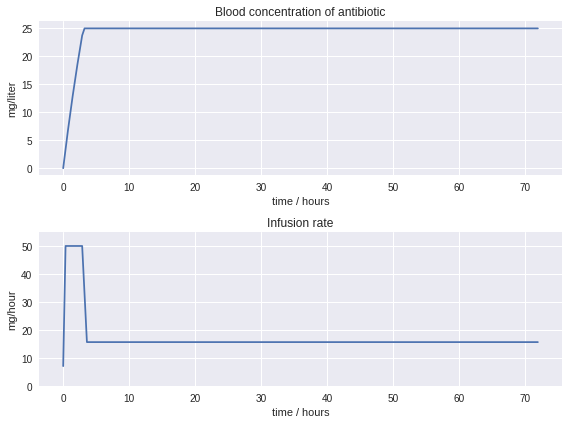

In [38]:
# parameters
t_final = 72     # hours
V = 5.0          # liters
k = 0.625        # liters/hour
u_max = 50       # mg/hour infusion rate
Csp = 25         # setpoint

# create a model
model = ConcreteModel()

# define time as a continous set with bounds
model.t = ContinuousSet(bounds=(0, t_final))

# define problem variable indexed by time
model.u = Var(model.t, bounds=(0, u_max))
model.C = Var(model.t, domain=NonNegativeReals)
model.dCdt = DerivativeVar(model.C, wrt=model.t)

# the differential equation is a constraint indexed by time
model.ode = Constraint(model.t, rule=lambda model, t: V*model.dCdt[t] == model.u[t] - k*model.C[t])

# initial condition
model.C[0].fix(0)

# objective
model.ise = Integral(model.t, wrt=model.t, rule=lambda model, t: (model.C[t] - Csp)**2)
model.obj = Objective(expr=model.ise, sense=minimize)

# transform the model to a system of algebraic constraints
TransformationFactory('dae.finite_difference').apply_to(model, nfe=200, method='backwards')

# simulation
SolverFactory('ipopt', executable=ipopt_executable).solve(model)

# extract solutions from the model
tsim = [t for t in model.t]
Csim = [model.C[t]() for t in model.t]
usim = [model.u[t]() for t in model.t]

# plot results
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(tsim, Csim)
plt.title('Blood concentration of antibiotic')
plt.xlabel('time / hours')
plt.ylabel('mg/liter')

plt.subplot(2,1,2)
plt.plot(tsim, usim)
plt.ylim((0, 1.1*u_max))
plt.title('Infusion rate')
plt.xlabel('time / hours')
plt.ylabel('mg/hour')

plt.tight_layout()

The result of this optimization is a much better therapy for the patient. Therapuetic levels of antibiotic are reach with 3 hours thereby leading to an earlier outcome and the possibility of an earlier recovery.


## Alternative Objectives



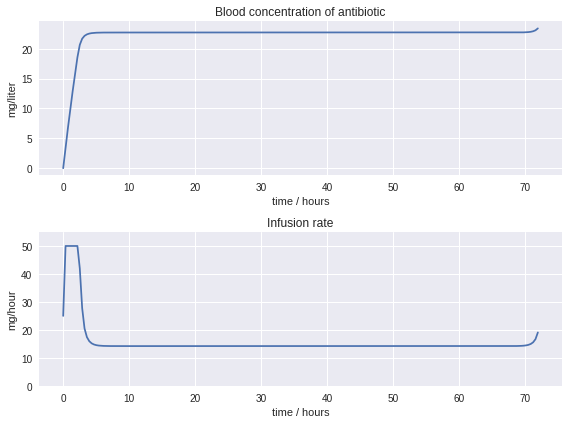

In [39]:
# parameters
t_final = 72     # hours
V = 5.0          # liters
k = 0.625        # liters/hour
u_max = 50       # mg/hour infusion rate
C_mtd = 20         # setpoint

# create a model
model = ConcreteModel()

# define time as a continous set with bounds
model.t = ContinuousSet(bounds=(0, t_final))

# define problem variable indexed by time
model.err = Var(model.t, domain=NonNegativeReals)
model.u = Var(model.t, bounds=(0, u_max))
model.C = Var(model.t, bounds=(0, 25))
model.dCdt = DerivativeVar(model.C, wrt=model.t)

# the differential equation is a constraint indexed by time
model.ode = Constraint(model.t, rule=lambda model, t: V*model.dCdt[t] == model.u[t] - k*model.C[t])

# initial condition
model.C[0].fix(0)

# objective
model.edef = Constraint(model.t, rule=lambda model, t: model.err[t] >= C_mtd - model.C[t])
model.iae = Integral(model.t, wrt=model.t, rule=lambda model, t: model.err[t]**2)
model.obj = Objective(expr=model.iae, sense=minimize)

# transform the model to a system of algebraic constraints
TransformationFactory('dae.finite_difference').apply_to(model, nfe=200, method='backwards')

# simulation
SolverFactory('ipopt', executable=ipopt_executable).solve(model)

# extract solutions from the model
tsim = [t for t in model.t]
Csim = [model.C[t]() for t in model.t]
usim = [model.u[t]() for t in model.t]

# plot results
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(tsim, Csim)
plt.title('Blood concentration of antibiotic')
plt.xlabel('time / hours')
plt.ylabel('mg/liter')

plt.subplot(2,1,2)
plt.plot(tsim, usim)
plt.ylim((0, 1.1*u_max))
plt.title('Infusion rate')
plt.xlabel('time / hours')
plt.ylabel('mg/hour')

plt.tight_layout()

<!--NAVIGATION-->
< [Simulation and Optimal Control](http://nbviewer.jupyter.org/github/jckantor/CBE30338/blob/master/notebooks/07.00-Simulation-and-Optimal-Control.ipynb) | [Contents](toc.ipynb) | [Soft Landing a Rocket](http://nbviewer.jupyter.org/github/jckantor/CBE30338/blob/master/notebooks/07.02-Soft-Landing-a-Rocket.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE30338/blob/master/notebooks/07.01-Simulation-and-Optimal-Control-in-Pharmacokinetics.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE30338/master/notebooks/07.01-Simulation-and-Optimal-Control-in-Pharmacokinetics.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>